,ds,cnp_np,cnp_se,cnp_no,cnp_dk,cnp_fi
8976,2021-12-10 00:00:00,52.59,18.30,18.45,3.96,11.87
8977,2021-12-10 01:00:00,51.52,17.92,18.09,3.82,11.69
8978,2021-12-10 02:00:00,50.81,17.48,17.96,3.73,11.64
8979,2021-12-10 03:00:00,51.06,17.65,17.91,3.75,11.75
8980,2021-12-10 04:00:00,51.65,17.87,17.90,3.79,12.10
8981,2021-12-10 05:00:00,53.58,18.39,18.33,4.01,12.84
8982,2021-12-10 06:00:00,57.52,20.17,19.52,4.65,13.17
8983,2021-12-10 07:00:00,60.98,21.60,20.78,5.26,13.35
8984,2021-12-10 08:00:00,61.65,21.85,21.12,5.49,13.19
8985,2021-12-10 09:00:00,61.42,21.90,21.05,5.46,13.01


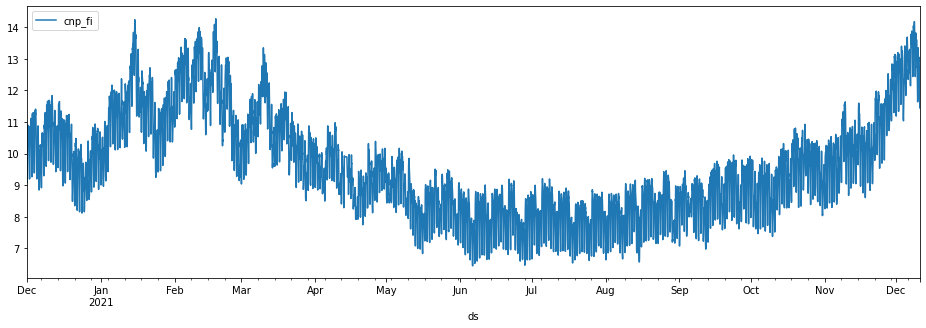

In [207]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
import os
import logging
import urllib.parse as url
import warnings
import numpy as np

warnings.filterwarnings("ignore")

# data_series = [
#     'CNPNP',
#     'CNPSE', 'CNPSE1', 'CNPSE2', 'CNPSE3', 'CNPSE4',
#     'CNPNO', 'CNPNO1', 'CNPNO2', 'CNPNO3',
#     'CNPDEN', 'CNPDK1', 'CNPDK2',
#     'CNPFI'
# ]
# column_names = [
#     'cnp_np',
#     'cnp_se', 'cnp_se1', 'cnp_se2', 'cnp_se3', 'cnp_se4',
#     'cnp_no', 'cnp_no1', 'cnp_no2', 'cnp_no3',
#     'cnp_dk', 'cnp_dk1', 'cnp_dk2',
#     'cnp_fi'
# ]

data_series = [
    'CNPNP',
    'CNPSE',
    'CNPNO',
    'CNPDEN',
    'CNPFI'
]
column_names = [
    'cnp_np',
    'cnp_se',
    'cnp_no',
    'cnp_dk',
    'cnp_fi'
]

# data_series = [
#     'CNPNP',
#     'CNPSE',
#     'CNPNO',
#     'CNPFI'
# ]
# column_names = [
#     'cnp_np',
#     'cnp_se',
#     'cnp_no',
#     'cnp_fi'
# ]

history_start_date = datetime(year=2020, month=12, day=1)
history_end_date = datetime(year=2021, month=12, day=1)
forecast_end_date = datetime(year=2021, month=12, day=10)

request = {
    "series": ','.join(data_series),
    'interval': 'hour',
    'start': history_start_date.strftime('%Y-%m-%d'),
    'end': forecast_end_date.strftime('%Y-%m-%d'),
    'token': '8ycj3jSf2DJZOtX',
    #'token': '7EMf0VCcZxcIdBy',
    'emptydata': 'yes',
    'currency': '',
    'dateFormat': 'nbno',
    'numberFormat': 'nothousandsdot',
    'fileformat': 'csv',
    'headers': 'no'
}

dataUrl = f'https://syspower5.skm.no/api/webquery/execute?{url.urlencode(request)}'
data = pd.read_csv(dataUrl, sep=';', index_col=0, parse_dates=True, dayfirst=True,
                   header=None, names = ['ds'] + column_names).interpolate().reset_index()
#
# plt.figure(figsize=(16, 6))
# data.plot(x='ds', y='cnp_np', figsize=(16, 5))
data.plot(x='ds', y='cnp_fi', figsize=(16, 5))
# data.plot(x='ds', y='cnp_se', figsize=(16, 5))
# data.plot(x='ds', y='cnp_se1', figsize=(16, 5))
# data.plot(x='ds', y='cnp_se2', figsize=(16, 5))
# data.plot(x='ds', y='cnp_se3', figsize=(16, 5))
# data.plot(x='ds', y='cnp_se4', figsize=(16, 5))
# data.plot(x='ds', y='cnp_no', figsize=(16, 5))
# data.plot(x='ds', y='cnp_no1', figsize=(16, 5))
# data.plot(x='ds', y='cnp_no2', figsize=(16, 5))
# data.plot(x='ds', y='cnp_no3', figsize=(16, 5))
# data.plot(x='ds', y='cnp_dk', figsize=(16, 5))
# data.plot(x='ds', y='cnp_dk1', figsize=(16, 5))
# data.plot(x='ds', y='cnp_dk2', figsize=(16, 5))
data.tail(24)

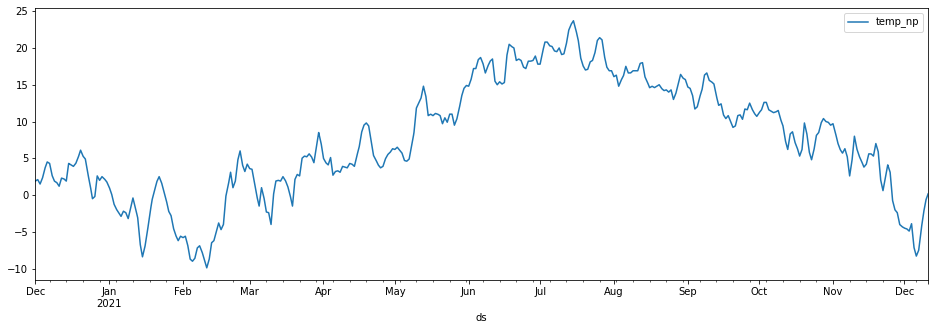

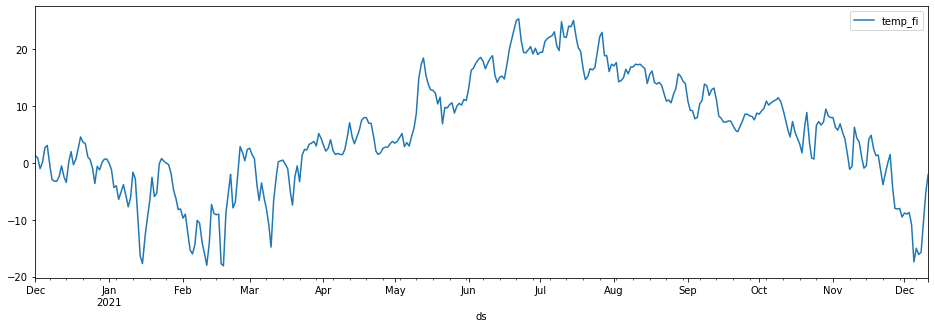

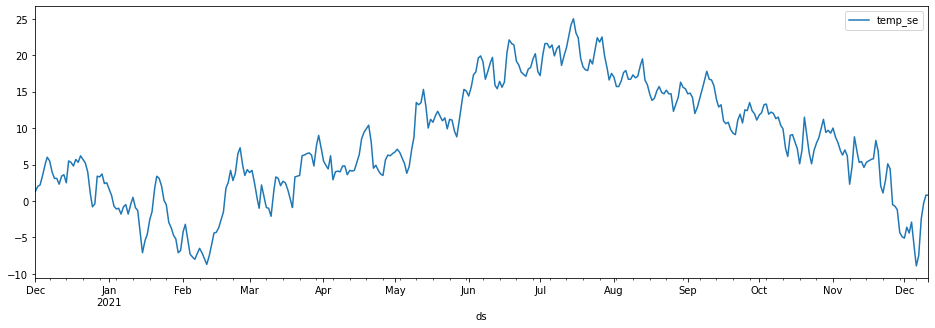

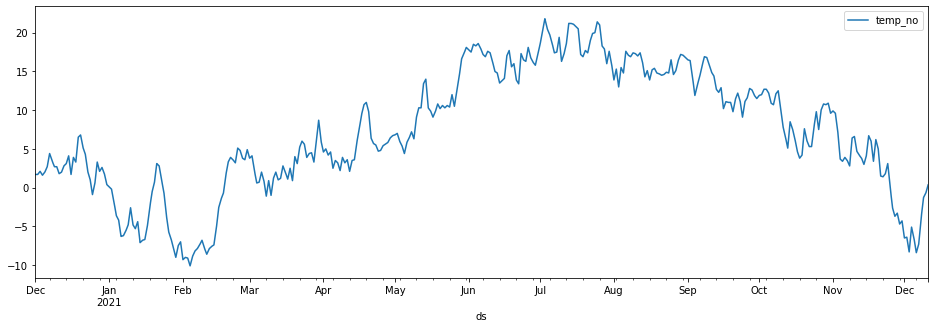

In [208]:
data_series_exog = [
    'SMHITEMPFI_F', 'SMHITEMPSE_F', 'SMHITEMPNO_F', 'SMHITEMPNP_F', 'SMHITEMPDK_F'
]
column_names_exog = [
    'temp_fi', 'temp_se', 'temp_no', 'temp_np', 'temp_dk'
]

temp_date = forecast_end_date + timedelta(days=1)
request = {
    "series": ','.join(data_series_exog),
    'interval': 'day',
    'start': history_start_date.strftime('%Y-%m-%d'),
    'end': temp_date.strftime('%Y-%m-%d'),
    'token': '8ycj3jSf2DJZOtX',
    'emptydata': 'yes',
    'currency': '',
    'dateFormat': 'nbno',
    'numberFormat': 'nothousandsdot',
    'fileformat': 'csv',
    'headers': 'no'
}

dataUrl = f'https://syspower5.skm.no/api/webquery/execute?{url.urlencode(request)}'
temp_data = pd.read_csv(dataUrl, sep=';', index_col=0, parse_dates=True, dayfirst=True,
                   header=None, names = ['ds'] + column_names_exog).interpolate().reset_index()

temp_data['ds'] = pd.to_datetime(temp_data['ds'])
temp_data.set_index('ds', inplace=True)
temp_data = temp_data.resample('H').interpolate()
temp_data = temp_data.reset_index()
temp_data = temp_data[lambda x: x['ds'] < temp_date]
temp_data.plot(x='ds', y='temp_np', figsize=(16, 5))
temp_data.plot(x='ds', y='temp_fi', figsize=(16, 5))
temp_data.plot(x='ds', y='temp_se', figsize=(16, 5))
temp_data.plot(x='ds', y='temp_no', figsize=(16, 5))
data = pd.merge(left=data, right=temp_data, on='ds', how='left')

In [209]:
#!pip install pytorch_forecasting pytorch_lightning pandas

Here we create function that pivot source data to the shape that pytorch forecasting expects

In [210]:
def create_dataset(df: pd.DataFrame, column_names: list) -> pd.DataFrame:
    result = df.melt(
        id_vars=['ds'],
        value_vars=column_names
    )
    groups_dict = {key: value for value, key in enumerate(column_names)}
    time_idx = np.tile(np.arange(data.shape[0]), len(column_names))
    result['time_idx'] = time_idx
    result['group'] = result.apply(lambda x: groups_dict.get(x['variable'], 0), axis=1)

    result['date'] = result.apply(lambda x: pd.to_datetime(x['ds'].date()), axis=1)

    special_days = pd.read_excel('syspower_dict.xlsx', 'calendar')
    special_days.columns = ['date', 'variable', 'sd_value']
    special_days['sd_value'] = special_days['sd_value'] + 1
    special_days['variable'] = special_days.apply(lambda x: 'cnp_' + x['variable'].lower(), axis=1)

    result = pd.merge(left=result, right=special_days, on=['date', 'variable'], how='left').fillna(value=0).drop_duplicates().reset_index(drop=True)

    result['hour'] = result.apply(lambda x: x['ds'].hour, axis=1).astype(str).astype('category')
    result['weekday'] = result.apply(lambda x: x['ds'].weekday(), axis=1).astype(str).astype('category')
    result['month'] = result.apply(lambda x: x['ds'].month, axis=1).astype(str).astype('category')
    result['sd_value'] = result['sd_value'].astype(str).astype('category')
    return result

In [211]:
def add_covariates(df: pd.DataFrame, target_column_names: list) -> pd.DataFrame:
    df_list = [df] * len(target_column_names)
    result_df = pd.concat(df_list, ignore_index=True)
    return result_df

In [212]:
# res = data.melt(
#     id_vars=['ds'],
#     value_vars=[
#         'cnp_np',
#         'cnp_no', 'cnp_no1', 'cnp_no2', 'cnp_no3',
#         'cnp_se', 'cnp_se1', 'cnp_se2', 'cnp_se3', 'cnp_se4',
#         'cnp_dk', 'cnp_dk1', 'cnp_dk2',
#         'cnp_fi'
#     ]
# )
# time_idx = np.tile(np.arange(data.shape[0]), 14)
# temperature = np.tile(
#     data.loc[:, ['temp_fi', 'temp_np', 'temp_no', 'temp_se']].to_numpy(),
#     (14, 1)
# )
# res['time_idx'] = time_idx
# res['temp_fi'] = temperature[:, 0]
# res['temp_np'] = temperature[:, 1]
# res['temp_no'] = temperature[:, 2]
# res['temp_se'] = temperature[:, 3]
# groups_dict = {
#     'cnp_np': 1,
#     'cnp_no': 2,
#     'cnp_no1': 3,
#     'cnp_no2': 4,
#     'cnp_no3': 5,
#     'cnp_se': 6,
#     'cnp_se1': 7,
#     'cnp_se2': 8,
#     'cnp_se3': 9,
#     'cnp_se4': 10,
#     'cnp_dk': 11,
#     'cnp_dk1': 12,
#     'cnp_dk2': 13,
#     'cnp_fi': 14,
# }
# res['group'] = res.apply(lambda x: groups_dict.get(x['variable'], 0), axis=1)

In [213]:
res = create_dataset(df=data, column_names=column_names)
exog_df = add_covariates(df=temp_data, target_column_names=column_names).drop(columns='ds')
res = pd.concat([res, exog_df], axis=1)

In [214]:
training_data = res[lambda x: x['ds'] < history_end_date]
testing_data = res[lambda x: x['ds'] >= history_end_date]

In [215]:
#column_names_exog.extend(['hour', 'weekday'])

In [216]:
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import GroupNormalizer, MultiNormalizer, EncoderNormalizer
from sklearn.preprocessing import StandardScaler, RobustScaler

encoder_length = 120
decoder_length = 24

training_cutoff = res['time_idx'].max() - decoder_length
training_dataset = TimeSeriesDataSet(
    training_data[lambda x: x.time_idx <= training_cutoff],
    group_ids=['group'],
    target='value',
    time_idx='time_idx',
    min_encoder_length=encoder_length,
    max_encoder_length=encoder_length,
    min_prediction_length=decoder_length,
    max_prediction_length=decoder_length,
    time_varying_unknown_reals=['value'],
    time_varying_known_reals=column_names_exog,
    time_varying_known_categoricals=['hour', 'weekday', 'month', 'sd_value'],
    scalers={'std_scale': EncoderNormalizer()},
    target_normalizer=EncoderNormalizer(transformation='softplus'),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True
    #scalers={'encoder_normalizer': EncoderNormalizer()},
)
validation_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset,
    training_data,
    predict=True,
    stop_randomization=True
)
batch_size = 64
train_dataloader = training_dataset.to_dataloader(
    train=True,
    batch_size=batch_size,
    num_workers=0
)
val_dataloader = validation_dataset.to_dataloader(
    train=False,
    batch_size=batch_size,
    num_workers=0
)

In [217]:
import pytorch_forecasting as pf
from pytorch_forecasting.metrics import SMAPE, QuantileLoss
#{'gradient_clip_val': 0.09709617603052763, 'hidden_size': 41, 'dropout': 0.11932939385585195, 'hidden_continuous_size': 26, 'attention_head_size': 3, 'learning_rate': 0.09010237706969171}
model = pf.TemporalFusionTransformer.from_dataset(
    training_dataset,
    hidden_size=64,
    lstm_layers=2,
    hidden_continuous_size=16,
    dropout=0.1,
    #loss=SMAPE(),
    output_size=7,
    loss=QuantileLoss(),
    attention_head_size=4,
    learning_rate=5e-3,
    reduce_on_plateau_patience=4
)

In [218]:
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

pl.seed_everything(666)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=10,
    verbose=False,
    mode='min'
)

trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,
    weights_summary='top',
    callbacks=[early_stop_callback],
    limit_train_batches=30,
    gradient_clip_val=0.1
)

Global seed set to 666
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [219]:
# import pickle
#
# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
#
# # create study
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path="optuna_test",
#     n_trials=100,
#     max_epochs=50,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs=dict(limit_train_batches=30),
#     reduce_on_plateau_patience=4,
#     use_learning_rate_finder=False,
#     verbose=True# use Optuna to find ideal learning rate or use in-built learning rate finder
# )
#
# # save study results - also we can resume tuning at a later point in time
# with open("test_study.pkl", "wb") as fout:
#     pickle.dump(study, fout)
#
# # show best hyperparameters
# print(study.best_trial.params)

In [220]:
 # find optimal learning rate
# res = trainer.tuner.lr_find(
#     model,
#     train_dataloader=train_dataloader,
#     val_dataloaders=val_dataloader,
#     max_lr=1.0,
#     min_lr=1e-3,
# )
#
# print(f"suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()

In [221]:
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 325   
3  | prescalers                         | ModuleDict                      | 320   
4  | static_variable_selection          | VariableSelectionNetwork        | 9.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 24.9 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 21.4 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 16.8 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 16.8 K
9  | static_context_initial_cell_lstm 

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 666


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [222]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = pf.TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [223]:
# pred, x = best_model.predict(val_dataloader, mode='prediction', return_x=True)

In [224]:
# y = res.loc[:, 'value'].to_numpy()[-decoder_length:]
# yhat = pred.detach().numpy()[-1, :]

In [225]:
# forecast_res = pd.DataFrame(
#     {'y': y, 'yhat': yhat}
# )
# forecast_res.plot(figsize=(16, 6))

In [226]:
# from sklearn.metrics import mean_absolute_error
#
# mae = mean_absolute_error(y_true=forecast_res.loc[:, 'y'].to_numpy(), y_pred=forecast_res.loc[:, 'yhat'])
# print(f'MAE = {mae}')

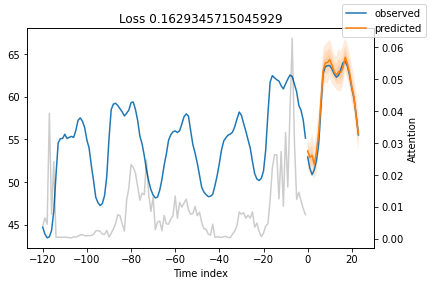

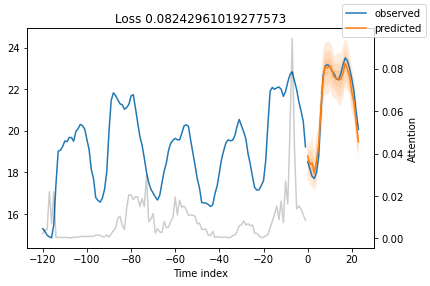

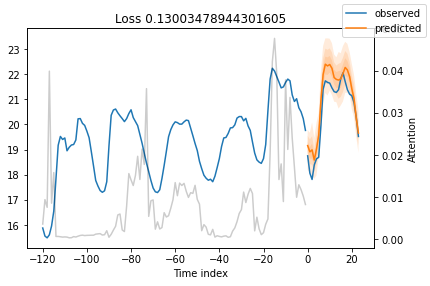

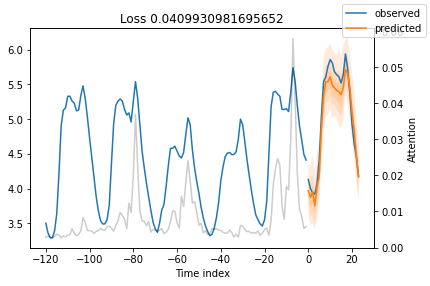

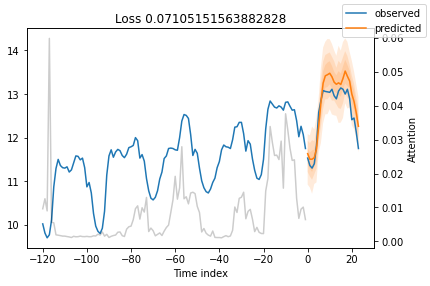

In [227]:
raw_predictions, x = best_model.predict(val_dataloader, mode='raw', return_x=True)
for index in range(len(column_names)):
    best_model.plot_prediction(x, raw_predictions, idx=index, add_loss_to_title=True)

In [228]:
data['cnp_fi_pred'] = 0

dates_range = pd.date_range(
    start=history_end_date + timedelta(hours=decoder_length),
    end=forecast_end_date,
    freq='D'
)
for current_date in dates_range:
    # cur_df = res.loc[
    #     (res['ds'] >= current_date - timedelta(hours=encoder_length+decoder_length)) &
    #     (res['ds'] < current_date),
    #     :
    # ]
    cur_df = res.loc[
         (res['ds'] >= current_date - timedelta(hours=encoder_length+decoder_length)) &
         (res['ds'] < current_date),
         :
    ]
    prediction = best_model.predict(
        cur_df,
        mode='prediction',
        return_x=False
    )
    # testing_dataset = TimeSeriesDataSet(
    #     data=cur_df,
    #     group_ids=['group'],
    #     target='value',
    #     time_idx='time_idx',
    #     min_encoder_length=encoder_length,
    #     max_encoder_length=encoder_length,
    #     min_prediction_length=decoder_length,
    #     max_prediction_length=decoder_length,
    #     time_varying_unknown_reals=['value'],
    #     #time_varying_known_reals=['temp_fi'],
    #     #time_varying_known_reals=['temp_fi', 'temp_np', 'temp_no', 'temp_se'],
    #     time_varying_known_categoricals=['hour', 'weekday', 'month'],
    #     #scalers={'std_scale': EncoderNormalizer()},
    #     target_normalizer=EncoderNormalizer(transformation='softplus'),
    #     add_relative_time_idx=True,
    #     predict_mode=True
    #     #add_target_scales=True,
    # )
    # testing_dataset = TimeSeriesDataSet.from_dataset(
    #     dataset=training_dataset,
    #     data=cur_df,
    #     stop_randomization=True,
    #     predict=True
    # )
    # testing_dataloader = testing_dataset.to_dataloader(
    #     train=False,
    #     batch_size=batch_size,
    #     num_workers=0
    # )
    # prediction = best_model.predict(
    #     testing_dataloader,
    #     mode='prediction',
    #     return_x=False
    # )
    print(current_date)
    data.loc[
        (data['ds'] >= current_date - timedelta(days=1)) &
        (data['ds'] < current_date),
        'cnp_fi_pred'
    ] = prediction.detach().numpy()[-1, :]
#data.tail(24)

2021-12-02 00:00:00
2021-12-03 00:00:00
2021-12-04 00:00:00
2021-12-05 00:00:00
2021-12-06 00:00:00
2021-12-07 00:00:00
2021-12-08 00:00:00
2021-12-09 00:00:00
2021-12-10 00:00:00


<AxesSubplot:xlabel='ds'>

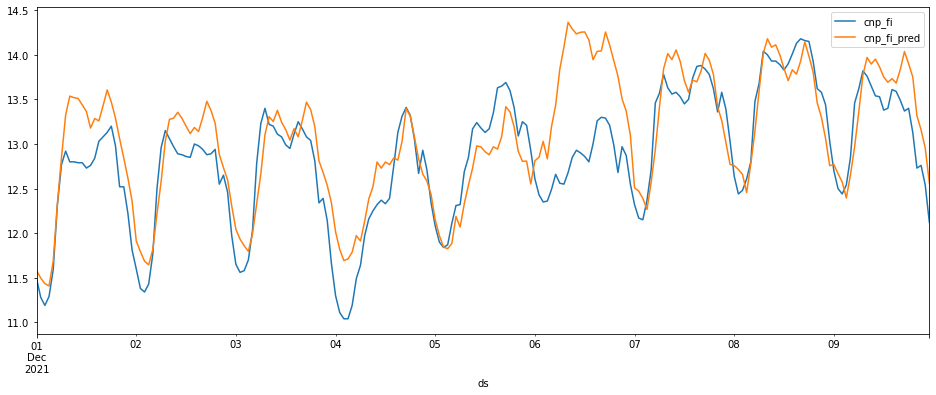

In [229]:
forecast_results = data.loc[
    (data['ds'] >= history_end_date) &
    (data['ds'] < forecast_end_date),
    ['ds', 'cnp_fi', 'cnp_fi_pred']
].set_index('ds')
forecast_results.plot(figsize=(16, 6))

<AxesSubplot:xlabel='ds'>

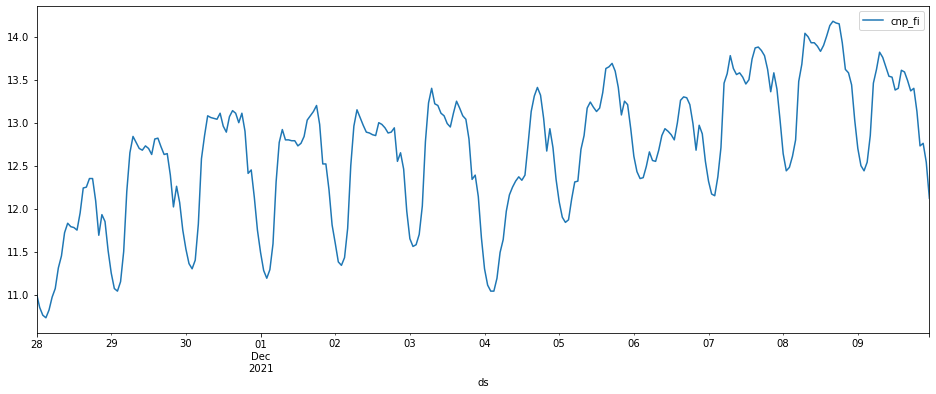

In [230]:
data.loc[
    (data['ds'] >= history_end_date - timedelta(days=3)) &
    (data['ds'] < forecast_end_date),
    ['ds', 'cnp_fi']
].set_index('ds').plot(figsize=(16, 6))

In [231]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(
    y_true=forecast_results.loc[:, 'cnp_fi'],
    y_pred=forecast_results.loc[:, 'cnp_fi_pred']
)
print(f'MAE = {mae}')

MAE = 0.3564253736425329


In [232]:
forecast_results.reset_index(inplace=True)

In [233]:
forecast_results['day'] = forecast_results.apply(lambda x: x['ds'].day, axis=1)
forecast_results['hour'] = forecast_results.apply(lambda x: x['ds'].hour, axis=1)
forecast_results['diff'] = forecast_results.apply(lambda x: np.abs(x['cnp_fi'] - x['cnp_fi_pred']), axis=1)
diff = forecast_results.groupby(by='day').max()['diff'].to_numpy()
diff = diff[diff <= 1]
np.mean(diff * 1000)

623.487057685852

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x198 with 1 Axes>,
 'encoder_variables': <Figure size 504x342 with 1 Axes>,
 'decoder_variables': <Figure size 504x324 with 1 Axes>}

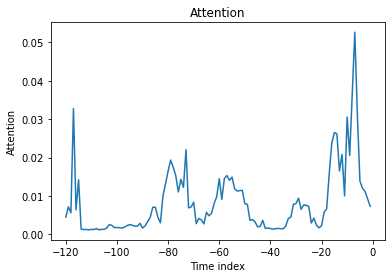

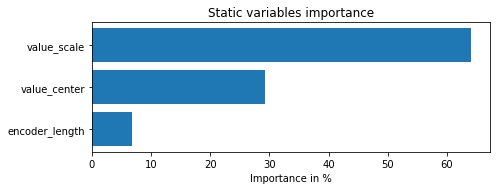

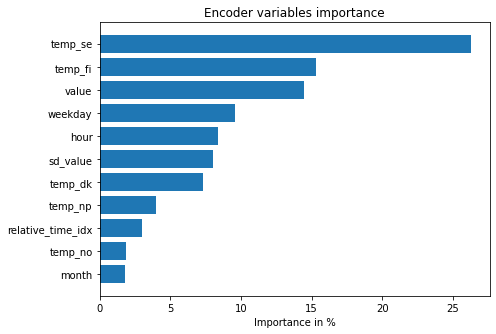

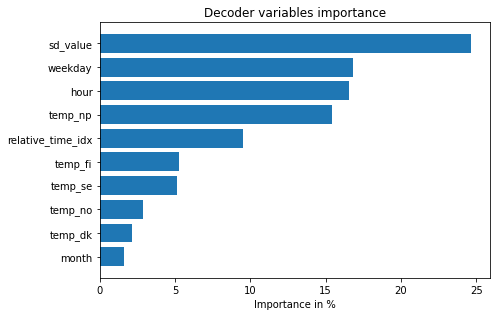

In [234]:
interpretation = best_model.interpret_output(raw_predictions, reduction="sum")
best_model.plot_interpretation(interpretation)

In [235]:
# training_data.head(24)